In [1]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import joblib

In [2]:
observed_emotion=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotions={f'0{i+1}':j for i,j in enumerate(observed_emotion)}

print(observed_emotion)
print(emotions)

['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
{'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}


In [3]:
def extract_features(file_path):

    y,sr = librosa.load(file_path, sr=None)
    features = np.array([])

    # Extract MFCC

    mfccs = np.mean(librosa.feature.mfcc(y=y,sr=sr, n_mfcc=13).T, axis=0)
    features = np.hstack((features,mfccs))

    # Extract chromagram

    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    features = np.hstack((features,chroma))


    #Extract Mel-scaled  spectogram

    mel = np.mean(librosa.feature.melspectrogram(y=y,sr=sr).T,axis=0)
    features = np.hstack((features,mel))

    #Extract spectral contrast

    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)
    features = np.hstack((features,contrast))

    # Extract tonnetz (tonal centroid)
    
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y),sr=sr).T, axis=0)
    features = np.hstack((features,tonnetz))

    return features

In [5]:
dataset_path = 'speech-emotion-recognition-ravdess-data/'
features = []
labels = []



for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)

    if not os.path.isdir(actor_path):
        continue
    
    for file_name in os.listdir(actor_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(actor_path, file_name)
            feature_vector = extract_features(file_path)
            emotion_label = int(file_name.split('-')[2])
            features.append(feature_vector)
            labels.append(emotion_label)

X = np.array(features)
y = np.array(labels)

print(f"Shape of feature array: {X.shape}")
print(f"Shape of label array: {y.shape}")


Shape of feature array: (1440, 166)
Shape of label array: (1440,)


In [6]:
df = pd.DataFrame(features)
df['emotion_label'] = labels

df.to_csv('emotion_features_1.csv', index=False)

In [7]:

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
standardized_data = pd.DataFrame(X_standardized)
standardized_data['emotion_label'] = y_encoded
standardized_csv_save_path = 'standardized_emotion_features_1.csv'
standardized_data.to_csv(standardized_csv_save_path, index=False)
# 
print(f"Standardized data successfully saved to {standardized_csv_save_path}")


Standardized data successfully saved to standardized_emotion_features_1.csv


In [9]:

from sklearn.utils import resample

# Load your dataset
data_path = 'emotion_features_1.csv'
data = pd.read_csv(data_path)


df = data.copy()  

min_samples = df['emotion_label'].value_counts().min()  

balanced_df = pd.DataFrame()  


for emotion in df['emotion_label'].unique():
    emotion_data = df[df['emotion_label'] == emotion]

    if len(emotion_data) < min_samples:
        emotion_data_balanced = resample(emotion_data, 
                                        replace=True, 
                                        n_samples=min_samples, 
                                        random_state=42)
    else:
        emotion_data_balanced = resample(emotion_data, 
                                        replace=False, 
                                        n_samples=min_samples, 
                                        random_state=42)


    balanced_df = pd.concat([balanced_df, emotion_data_balanced], ignore_index=True)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced DataFrame to CSV
balanced_csv_path = 'balanced_audio_features.csv'
balanced_df.to_csv(balanced_csv_path, index=False)

print(f"Balanced data successfully saved to {balanced_csv_path}")


Balanced data successfully saved to balanced_audio_features.csv


In [10]:
from sklearn.model_selection import train_test_split
balanced_df = pd.read_csv('balanced_audio_features.csv')

X = balanced_df.drop('emotion_label', axis=1)
y = balanced_df['emotion_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (614, 166)
Shape of X_test: (154, 166)
Shape of y_train: (614,)
Shape of y_test: (154,)


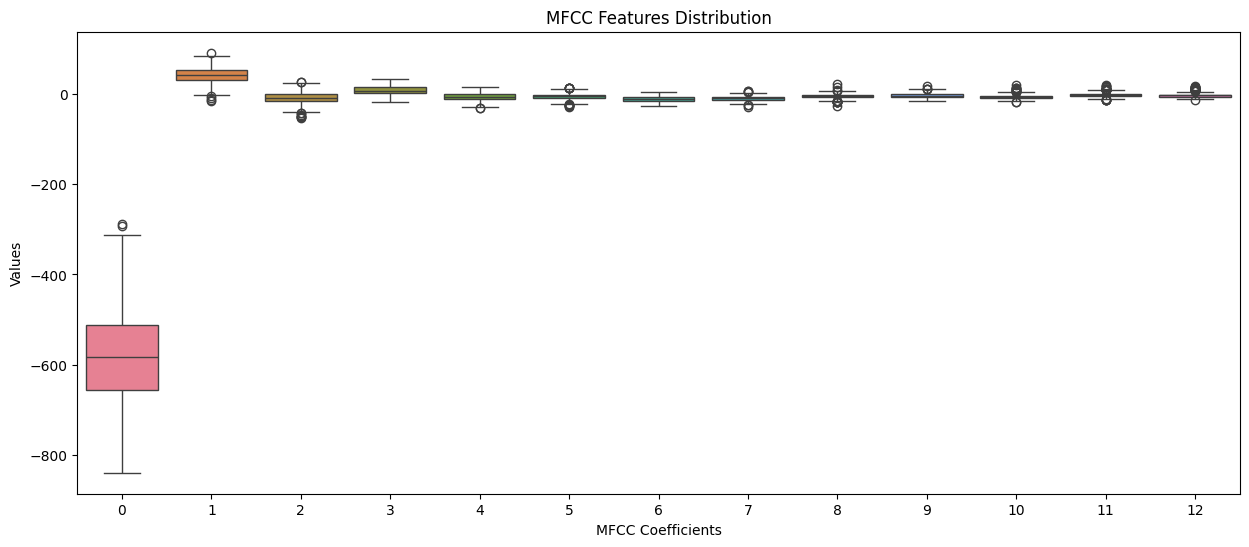

In [11]:
# MFCC
import seaborn as sns

# Assuming the MFCC features are in the first 13 columns of balanced_df
mfcc_features = balanced_df.iloc[:, 0:13]

# Create a boxplot for MFCC features
plt.figure(figsize=(15, 6))
sns.boxplot(data=mfcc_features)
plt.title('MFCC Features Distribution')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Values')
plt.show()

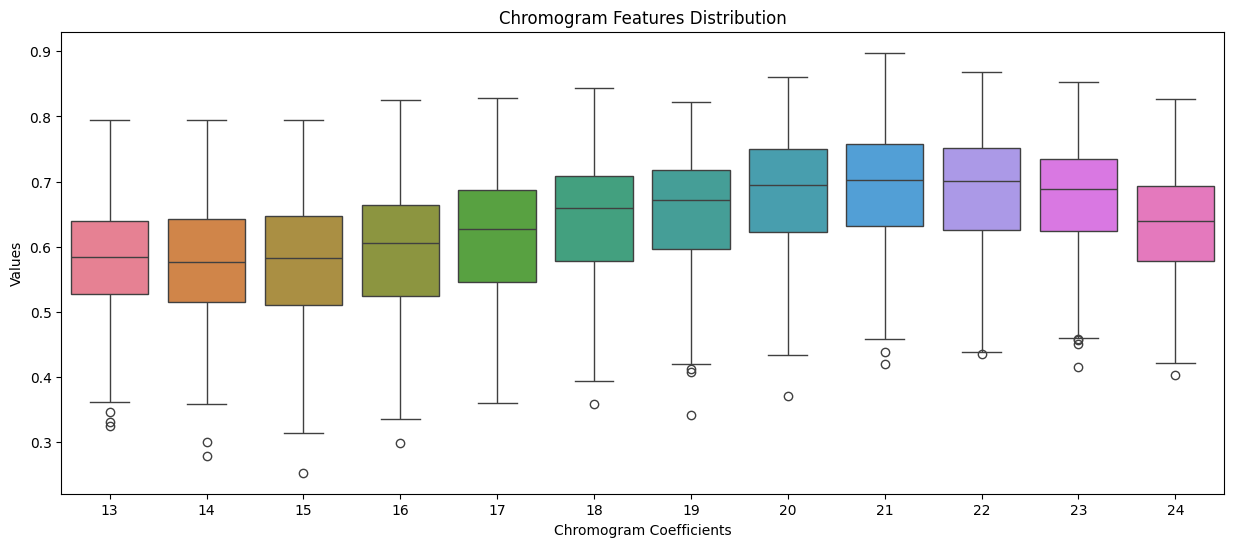

In [12]:
# Chromograph
chromaG_features = balanced_df.iloc[:, 13:25]
plt.figure(figsize=(15, 6))
sns.boxplot(data=chromaG_features)
plt.title('Chromogram Features Distribution')
plt.xlabel('Chromogram Coefficients')
plt.ylabel('Values')
plt.show()

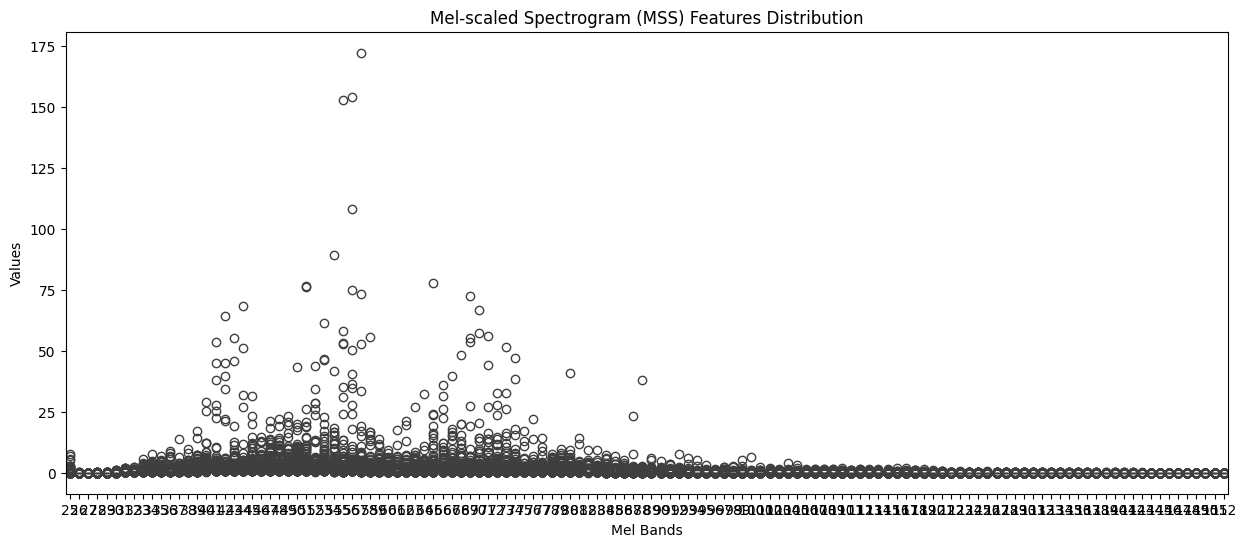

In [13]:
#MSS(mel-scaled spectrogram)
mss_features = balanced_df.iloc[:, 25:153]

plt.figure(figsize=(15, 6))
sns.boxplot(data=mss_features)
plt.title('Mel-scaled Spectrogram (MSS) Features Distribution')
plt.xlabel('Mel Bands')
plt.ylabel('Values')
plt.show()

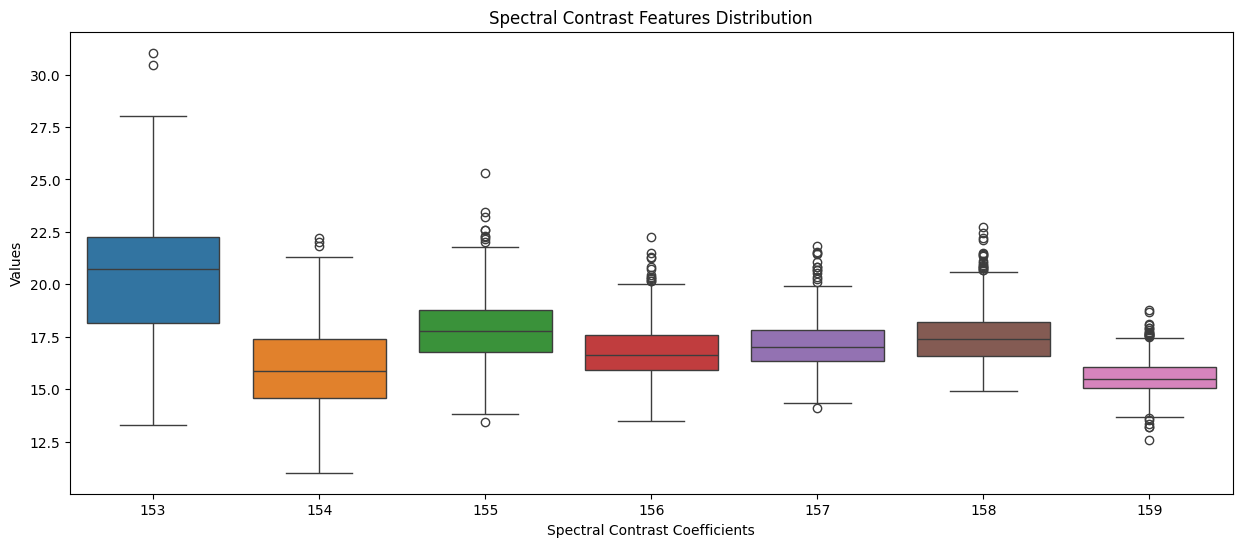

In [14]:
#Spectral contrast(sc)
sc_features = balanced_df.iloc[:, 153:160]
plt.figure(figsize=(15, 6))
sns.boxplot(data=sc_features)
plt.title('Spectral Contrast Features Distribution')
plt.xlabel('Spectral Contrast Coefficients')
plt.ylabel('Values')
plt.show()

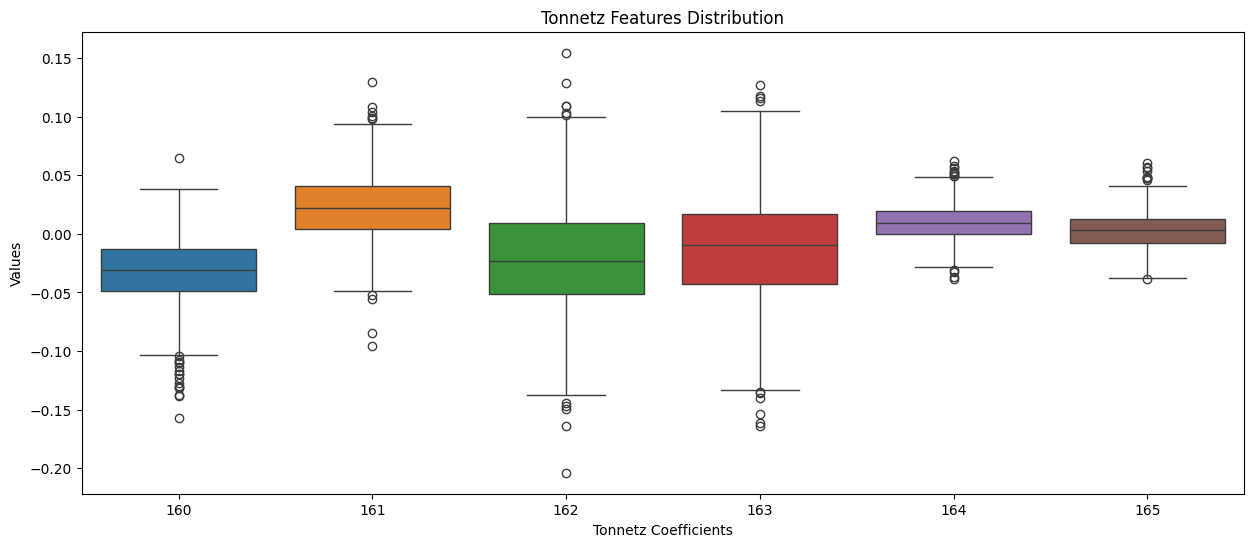

In [15]:
#Tonnetz
t_features = balanced_df.iloc[:, 160:166]
plt.figure(figsize=(15, 6))
sns.boxplot(data=t_features)
plt.title('Tonnetz Features Distribution')
plt.xlabel('Tonnetz Coefficients')
plt.ylabel('Values')
plt.show()

In [16]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# target_names=list(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Shape of X_scaled: {X_scaled.shape}")
print(f"Shape of y_encoded: {y_encoded.shape}")

Shape of X_scaled: (768, 166)
Shape of y_encoded: (768,)


In [18]:
from sklearn.metrics import accuracy_score, classification_report


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

mlp_classifier = MLPClassifier(hidden_layer_sizes=(150, 150, 150), max_iter=300, alpha=0.001, learning_rate_init=0.001, solver='adam', random_state=42, verbose=False)
mlp_classifier.fit(X_train, y_train)

y_predicted = mlp_classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, y_predicted)

class_names = [str(class_label) for class_label in label_encoder.classes_]
classification_rep = classification_report(y_test, y_predicted, target_names=class_names, labels=range(len(class_names)), zero_division=0)

print(f"Test Accuracy: {test_accuracy}")
print("Detailed Classification Report:")
print(classification_rep)


Test Accuracy: 0.5324675324675324
Detailed Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.53      0.53        19
           2       0.67      0.53      0.59        19
           3       0.50      0.47      0.49        19
           4       0.45      0.45      0.45        20
           5       0.67      0.74      0.70        19
           6       0.42      0.42      0.42        19
           7       0.44      0.55      0.49        20
           8       0.65      0.58      0.61        19

    accuracy                           0.53       154
   macro avg       0.54      0.53      0.53       154
weighted avg       0.54      0.53      0.53       154



In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distribution = {
    'hidden_layer_sizes': [(128, 64), (256, 128), (512,)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'lbfgs'],
    'learning_rate_init': uniform(1e-4, 1e-1), 
    'max_iter': [300, 600, 900]
}

mlp_model = MLPClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=mlp_model, 
                                param_distributions=param_distribution, 
                                n_iter=30, 
                                n_jobs=-1, 
                                cv=5, 
                                verbose=2, 
                                random_state=42)

random_search.fit(X_scaled, y_encoded)

print('Optimal parameters found: ', random_search.best_params_)
print('Best cross-validated score: ', random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END activation=relu, hidden_layer_sizes=(128, 64), learning_rate_init=0.018443478986616378, max_iter=300, solver=adam; total time=   2.1s
[CV] END activation=relu, hidden_layer_sizes=(128, 64), learning_rate_init=0.018443478986616378, max_iter=300, solver=adam; total time=   2.3s
[CV] END activation=relu, hidden_layer_sizes=(128, 64), learning_rate_init=0.018443478986616378, max_iter=300, solver=adam; total time=   3.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 64), learning_rate_init=0.018443478986616378, max_iter=300, solver=adam; total time=   2.8s
[CV] END activation=relu, hidden_layer_sizes=(128, 64), learning_rate_init=0.018443478986616378, max_iter=300, solver=adam; total time=   4.5s
[CV] END activation=relu, hidden_layer_sizes=(256, 128), learning_rate_init=0.015699452033620265, max_iter=900, solver=adam; total time=   6.3s
[CV] END activation=logistic, hidden_layer_sizes=(128, 64), learning_rate_init=

In [20]:
from sklearn.metrics import accuracy_score


simple_model = MLPClassifier(random_state=9)
simple_model.fit(X_train, y_train)


optimal_parameters = random_search.best_params_

improved_model = MLPClassifier(**optimal_parameters, random_state=9)
improved_model.fit(X_train, y_train)

# Make predictions with both models
predictions_simple = simple_model.predict(X_test)
predictions_improved = improved_model.predict(X_test)

# Calculate accuracy for both models
accuracy_simple = accuracy_score(y_test, predictions_simple)
accuracy_improved = accuracy_score(y_test, predictions_improved)

# Print the accuracy results
print('Accuracy of Simple Model: ', accuracy_simple)
print('Accuracy of Improved Model: ', accuracy_improved)


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of Simple Model:  0.474025974025974
Accuracy of Improved Model:  0.4935064935064935


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#  Simple Model
print("Performance Metrics for Basic Model:")
print("Weighted Precision: ", precision_score(y_test, predictions_simple, average='weighted'))
print("Weighted Recall: ", recall_score(y_test, predictions_simple, average='weighted'))
print("Weighted F1 Score: ", f1_score(y_test, predictions_simple, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions_simple))
print("Detailed Classification Report:\n", classification_report(y_test, predictions_simple))

# Improved Model
print("\nPerformance Metrics for Optimized Model:")
print("Weighted Precision: ", precision_score(y_test, predictions_improved, average='weighted'))
print("Weighted Recall: ", recall_score(y_test, predictions_improved, average='weighted'))
print("Weighted F1 Score: ", f1_score(y_test, predictions_improved, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions_improved))
print("Detailed Classification Report:\n", classification_report(y_test, predictions_improved))
report=classification_report(y_test, predictions_improved)


Performance Metrics for Basic Model:
Weighted Precision:  0.4670343078956524
Weighted Recall:  0.474025974025974
Weighted F1 Score:  0.46582875240610333
Confusion Matrix:
 [[11  4  2  1  0  1  0  0]
 [ 3 13  0  2  0  0  1  0]
 [ 1  1  7  0  5  0  3  2]
 [ 1  4  3  4  0  4  3  1]
 [ 0  0  1  1 10  3  3  1]
 [ 1  1  0  3  2  8  3  1]
 [ 0  1  2  1  2  1 10  3]
 [ 4  0  2  0  0  0  3 10]]
Detailed Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.58      0.55        19
           1       0.54      0.68      0.60        19
           2       0.41      0.37      0.39        19
           3       0.33      0.20      0.25        20
           4       0.53      0.53      0.53        19
           5       0.47      0.42      0.44        19
           6       0.38      0.50      0.43        20
           7       0.56      0.53      0.54        19

    accuracy                           0.47       154
   macro avg       0.47      0.48   

In [23]:
from sklearn.model_selection import KFold, RandomizedSearchCV


kf_split = KFold(n_splits=5, shuffle=True, random_state=9)

search_model = RandomizedSearchCV(
    estimator=mlp_model, 
    param_distributions=param_distribution, 
    n_iter=50, 
    n_jobs=-1, 
    cv=kf_split, 
    verbose=2, 
    random_state=9
)

search_model.fit(X_scaled, y_encoded)


print('Optimal Parameters: ', search_model.best_params_)
print('Best Cross-Validation Score: ', search_model.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END activation=relu, hidden_layer_sizes=(128, 64), learning_rate_init=0.05028745921487388, max_iter=900, solver=adam; total time=   1.1s
[CV] END activation=relu, hidden_layer_sizes=(128, 64), learning_rate_init=0.05028745921487388, max_iter=900, solver=adam; total time=   1.2s
[CV] END activation=relu, hidden_layer_sizes=(128, 64), learning_rate_init=0.05028745921487388, max_iter=900, solver=adam; total time=   1.4s
[CV] END activation=relu, hidden_layer_sizes=(128, 64), learning_rate_init=0.05028745921487388, max_iter=900, solver=adam; total time=   2.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 64), learning_rate_init=0.05028745921487388, max_iter=900, solver=adam; total time=   2.7s
[CV] END activation=logistic, hidden_layer_sizes=(128, 64), learning_rate_init=0.02491011684135591, max_iter=300, solver=lbfgs; total time=   4.7s
[CV] END activation=logistic, hidden_layer_sizes=(128, 64), learning_rate_init=0.

/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.0009145044967880933, max_iter=900, solver=adam; total time= 2.4min
[CV] END activation=logistic, hidden_layer_sizes=(128, 64), learning_rate_init=0.020603089430621748, max_iter=600, solver=lbfgs; total time=   5.5s


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.0009145044967880933, max_iter=900, solver=adam; total time= 2.4min
[CV] END activation=logistic, hidden_layer_sizes=(128, 64), learning_rate_init=0.020603089430621748, max_iter=600, solver=lbfgs; total time=   6.6s


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.0009145044967880933, max_iter=900, solver=adam; total time= 2.5min
[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.051731741935395564, max_iter=900, solver=lbfgs; total time=  22.0s
[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.051731741935395564, max_iter=900, solver=lbfgs; total time=  22.0s
[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.051731741935395564, max_iter=900, solver=lbfgs; total time=  22.4s
[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.051731741935395564, max_iter=900, solver=lbfgs; total time=  24.0s
[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.051731741935395564, max_iter=900, solver=lbfgs; total time=  21.8s
[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.0003643692967551736, max_iter=900, solver=adam; tota

/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.0003643692967551736, max_iter=900, solver=adam; total time= 1.0min
[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.0003643692967551736, max_iter=900, solver=adam; total time= 1.0min


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(512,), learning_rate_init=0.0003643692967551736, max_iter=900, solver=adam; total time=  60.0s
Optimal Parameters:  {'activation': 'logistic', 'hidden_layer_sizes': (512,), 'learning_rate_init': np.float64(0.014311108545453855), 'max_iter': 900, 'solver': 'adam'}
Best Cross-Validation Score:  0.5272812155165096


In [24]:
from sklearn.model_selection import cross_val_score

best_parameters = search_model.best_params_

optimized_classifier = MLPClassifier(**best_parameters, random_state=9)
optimized_classifier.fit(X_scaled, y_encoded)

# Assess the model using cross-validation
cv_scores = cross_val_score(optimized_classifier, X_scaled, y_encoded, cv=kf_split, scoring='accuracy')
print("Cross-Validation Results: ", cv_scores)
print("Average Accuracy: ", np.mean(cv_scores))
print("Accuracy Standard Deviation: ", np.std(cv_scores))


Cross-Validation Results:  [0.50649351 0.54545455 0.57792208 0.50980392 0.52287582]
Average Accuracy:  0.5325099736864443
Accuracy Standard Deviation:  0.026514371546505492


In [25]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


# Split the dataset
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train the SVM model
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_set, y_train_set)
svm_predictions = svm_classifier.predict(X_test_set)
svm_accuracy = accuracy_score(y_test_set, svm_predictions)
svm_classification_report = classification_report(y_test_set, svm_predictions, target_names=class_names)

# Train the KNN model
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_set, y_train_set)
knn_predictions = knn_classifier.predict(X_test_set)
knn_accuracy = accuracy_score(y_test_set, knn_predictions)
knn_classification_report = classification_report(y_test_set, knn_predictions, target_names=class_names)

# Print results
print("Support Vector Machine Model")
print(f"Accuracy: {svm_accuracy:.4f}")
print("Classification Report:")
print(svm_classification_report)

print("\nK-Nearest Neighbors Model")
print(f"Accuracy: {knn_accuracy:.4f}")
print("Classification Report:")
print(knn_classification_report)

# Print MLP model results if defined
print("\nMulti-Layer Perceptron Model")
print(f"Accuracy: {accuracy_improved:.4f}")
print("Classification Report:")
print(report)


Support Vector Machine Model
Accuracy: 0.3961
Classification Report:
              precision    recall  f1-score   support

           1       0.35      0.47      0.40        19
           2       0.45      0.53      0.49        19
           3       0.17      0.21      0.19        19
           4       0.30      0.15      0.20        20
           5       0.50      0.63      0.56        19
           6       0.38      0.26      0.31        19
           7       0.43      0.45      0.44        20
           8       0.60      0.47      0.53        19

    accuracy                           0.40       154
   macro avg       0.40      0.40      0.39       154
weighted avg       0.40      0.40      0.39       154


K-Nearest Neighbors Model
Accuracy: 0.4610
Classification Report:
              precision    recall  f1-score   support

           1       0.32      0.84      0.46        19
           2       0.47      0.47      0.47        19
           3       0.39      0.37      0.38       